# hexapod 

# 1st excersise - calculate orientaiton and position 



In [100]:

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt



# base config


In [101]:

# SI units
actuator_min_leangth = 0.5
actuator_max_leangth = 0.8
Actuator_leangths = np.array([0.5,0.5,0.5,0.5,0.5,0.5])

Actuator_connection_base_distance = 0.3
Actuator_connection_top_distance = 0.2
Short_edge_deg = 20

Base_hexagon = np.zeros((6,3))

cg_above_top = np.array([0.4,0,0])
mass = 20 #kg







# Sample confguration of both bases


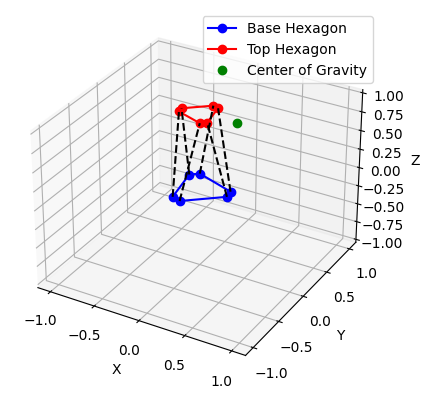

In [102]:

  
def Odd_heaxagon_base_3d(inner_edge_leangth, short_edge_deg, height):
    hexagon = np.zeros((6,3))
    angles = np.zeros(6)
    for i in range(6):
      short_angle = np.deg2rad(short_edge_deg)
      angle = np.deg2rad(120) - short_angle
      if i%2 == 0:
          angles[i] = angles[i-1]+short_angle
      else:
          angles[i] = angles[i-1]+angle
            
      hexagon[i] = [inner_edge_leangth*np.cos(angles[i]), inner_edge_leangth*np.sin(angles[i]), height]
    
    return hexagon
 
#numpy 60 deg roation matrix around z axis
def rotz(theta):
    R = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])
    return R
  
base_Translation = Odd_heaxagon_base_3d(Actuator_connection_base_distance,Short_edge_deg,0)
top_base_Translation = Odd_heaxagon_base_3d(Actuator_connection_top_distance,Short_edge_deg,1)


top_base_Translation = np.dot(top_base_Translation, rotz(np.deg2rad(60)))



# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot base hexagon
ax.plot(base_Translation[:, 0], base_Translation[:, 1], base_Translation[:, 2], 'bo-', label='Base Hexagon')

# Plot top hexagon
ax.plot(top_base_Translation[:, 0], top_base_Translation[:, 1], top_base_Translation[:, 2], 'ro-', label='Top Hexagon')

# Connect corresponding vertices of base and top hexagons
for i in range(6):
    ax.plot([base_Translation[i-1, 0], top_base_Translation[i, 0]],
            [base_Translation[i-1, 1], top_base_Translation[i, 1]],
            [base_Translation[i-1, 2], top_base_Translation[i, 2]], 'k--')

# plot center of gravity
ax.plot([cg_above_top[0]], [cg_above_top[1]], top_base_Translation[0, 2]+[cg_above_top[2]], 'go', label='Center of Gravity')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Equal aspect ratio
minbound = -1
maxbound = 1
ax.auto_scale_xyz([minbound, maxbound], [minbound, maxbound], [minbound, maxbound])

plt.show()



#


# Load calculation


M(Sum around a point) = 0
F(Sum) - F(Load) = 0


base_plate: [[ 2.81907786e-01  1.02606043e-01  0.00000000e+00]
 [-1.50000000e-01  2.59807621e-01  0.00000000e+00]
 [-2.29813333e-01  1.92836283e-01  0.00000000e+00]
 [-1.50000000e-01 -2.59807621e-01  0.00000000e+00]
 [-5.20944533e-02 -2.95442326e-01  0.00000000e+00]
 [ 3.00000000e-01 -3.39932334e-16  0.00000000e+00]]
payload_force: [   0.     0.  -196.2]
cg_relative_to_top_plate: [0.4 0.  0. ]
Result_Verified: True
Result_Max_Deviation: 3.552713678800501e-15
1: -0.19, 0.46, 109.18
2: -0.27, -0.07, 33.61
3: 0.01, 0.30, -72.18
4: -1.39, -0.07, -40.18
5: 2.21, 0.77, 55.69
6: -0.36, -1.40, 110.09


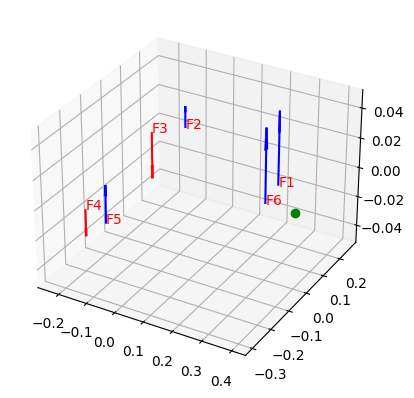

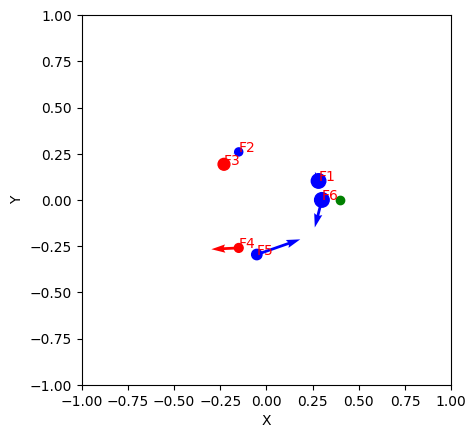

In [115]:
from matplotlib.pylab import f
import numpy as np
import scipy.optimize as opt

# Actuator load in 3D (2D matrix)

# Actuator loads is the variable to be solved
def moment_force_equalibrium_equation(actuator_loads, base_plate, force, cg_of_force_relative):
    support_count = len(base_plate)
    actuator_loads = actuator_loads.reshape((support_count, 3))
    
    
    translation_result = np.zeros(3) + force
    for support_index in range(support_count):
        translation_result += actuator_loads[support_index]
    
    # around n-1 actuators
    # moment_result = np.zeros((support_count-1, 3))
    # for i in range(support_count-1):
    #   radius_vector = cg_of_force_relative-base_plate[i]
    #   force_vector = force
    #   moment_result[i] = -np.cross(radius_vector, force_vector)
    #   for ii in range(support_count):
    #     ii_radius_vector = base_plate[ii]-base_plate[i]
    #     moment_result[i] += np.cross(ii_radius_vector, actuator_loads[ii])
        
    # result = np.concatenate((translation_result, moment_result.flatten()))
    
    # around 1 point
    moment_result = np.zeros(3)
    # start_point = cg_of_force_relative # around com
    start_point = base_plate[0] # around first point
    # start_point = np.zeros(3)

    moment_result = +np.cross(cg_of_force_relative-start_point, force)
    for i in range(support_count):
      i_radius_vector = base_plate[i] - start_point
      i_force_vector = actuator_loads[i]
      moment_result += np.cross(i_radius_vector, i_force_vector)
    
    # around center
    
      
    #add extra needed 0 to match the shape of incoming actuator loads size
    result = np.concatenate((translation_result, moment_result.flatten()))
    diff = len(actuator_loads.flatten()) - len(result)
    result = np.concatenate((result, np.zeros(diff)))
    
    return result

def get_actuator_loads(base_plate, top_plate, cg_relative_to_top_plate, mass):
    # Assume the base plate is not rotated, only y forces 
    support_count = len(base_plate)
    actuator_loads = np.zeros((support_count, 3))
    payload_force = np.array([0, 0, -mass * 9.81])
    
    # actuator_loads = opt.fsolve(moment_force_equalibrium_equation, actuator_loads.flatten(), args=(base_plate, payload_force, cg_relative_to_top_plate[:3]), xtol=1e-50, full_output=True, maxfev=10000)
    
    # print the inputs to debug in other solver
    print("base_plate:", base_plate)
    print("payload_force:", payload_force)
    print("cg_relative_to_top_plate:", cg_relative_to_top_plate[:3])
    
    
    #other solver
    # actuator_loads = opt.root(moment_force_equalibrium_equation, actuator_loads.flatten(),args=(base_plate, payload_force, cg_relative_to_top_plate[:3]), method='broyden1', tol=1e-20, options={'maxiter': 10000})
    
    #other solver with bounds
    # Note this is a fake tollerance, the solver will not converge with this tollerance
    tollerance = 1e-15
    bounds = opt.Bounds([-1000]*len(actuator_loads.flatten()), [1000]*len(actuator_loads.flatten()))
    actuator_loads = opt.least_squares(moment_force_equalibrium_equation, actuator_loads.flatten(), bounds=bounds, xtol=tollerance, gtol=tollerance, ftol=tollerance ,args=(base_plate, payload_force, cg_relative_to_top_plate[:3]))
    
    
    verify = moment_force_equalibrium_equation(actuator_loads.x, base_plate, payload_force, cg_relative_to_top_plate[:3])
    
    
    actual_tollerance_needed = 1e-14
    if np.max(verify) < actual_tollerance_needed:
      print("Result_Verified: True")
      print("Result_Max_Deviation:", np.max(verify))
    else:
      print("Result_Verified: False")
      print("Result_Max_Deviation:", np.max(verify))
      # print solve calls, accuracy and if it converged
      print("Solver success:", actuator_loads.success)
      print("Solver message:", actuator_loads.message)
      print("Number of iterations:", actuator_loads.nfev)
      print("Solution:", actuator_loads.x)
      print("Residuals:", actuator_loads.fun)
    
    

    actuator_loads = actuator_loads.x.reshape((support_count, 3))
    return actuator_loads


result = get_actuator_loads(base_Translation, top_base_Translation, cg_above_top, mass)


# Plotting
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Plot force vectors at each base plate from base_Translation 
for i in range(6):
  #scale the force vector
  max_size = 0.05
  scaled_force = result[i] / np.max(np.abs(result)) * max_size
  colors = 'b' if result[i, 2] > 0 else 'r'
  ax.quiver(base_Translation[i, 0], base_Translation[i, 1], base_Translation[i, 2],
              scaled_force[0], scaled_force[1], scaled_force[2], color=colors)

# add identifier for each force vector
for i in range(6):
    ax.text(base_Translation[i, 0], base_Translation[i, 1], base_Translation[i, 2],
            f'F{i+1}', color='r')
    # no 2 decimals max
    print(f'{i+1}: {result[i][0]:.2f}, {result[i][1]:.2f}, {result[i][2]:.2f}')

# plot the cg aswell

ax.plot([cg_above_top[0]], [cg_above_top[1]], [cg_above_top[2]], 'go', label='Center of Gravity')

# # Equal aspect ratio
# minbound = -0.5
# maxbound = 0.5
# ax.auto_scale_xyz([minbound, maxbound], [minbound, maxbound], [minbound, maxbound])


# make a 2d plot of the forces
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cg_above_top[0], cg_above_top[1], 'go', label='Center of Gravity')
colors = ['b' if z > 0 else 'r' for z in result[:, 2]]
ax.quiver(base_Translation[:, 0], base_Translation[:, 1], result[:, 0], result[:, 1], color=colors)
#add a blob whose size corresponds to z force

ax.scatter(base_Translation[:, 0], base_Translation[:, 1], s=np.abs(result[:, 2]) * 1, c=colors)


for i in range(6):
    ax.text(base_Translation[i, 0], base_Translation[i, 1], f'F{i+1}', color='r') 
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# corrct scale
ax.set_xlim([minbound, maxbound])
ax.set_ylim([minbound, maxbound])

plt.show()
#